# 01 · 数据概览（ICU Lymphoma ML）

> 本 Notebook 用于快速检查原始/预处理数据的基本情况（样本量、变量类型、缺失、结局分布），并输出若干图表至 `outputs/figures/`。

温馨提示：本 Notebook 尽量**只读**数据，不做任何破坏性写入（除导出图表）。

In [8]:
# ! pip install numpy
# ! pip install pandas
# ! pip install matplotlib
# ! pip install yaml

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml


In [15]:
# 安装缺失依赖（仅首次需要）
import sys, subprocess
def ensure(pkg, pip_name=None):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg])

ensure("yaml", "pyyaml")


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.3/770.3 KB 928.1 kB/s eta 0:00:00


In [1]:
# %% [imports & paths]
from pathlib import Path
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yaml

PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PROJECT_ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
CONF_PATH = PROJECT_ROOT / "conf" / "config.yaml"

print(f"[cwd] {Path.cwd()}")
print(f"[conf] {CONF_PATH}")

with open(CONF_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

PROC_DIR = PROJECT_ROOT / CFG.get("data", {}).get("processed_dir", "data_processed")
RAW_DIR  = PROJECT_ROOT / CFG.get("data", {}).get("raw_dir", "data_raw")
OUTCOME  = CFG.get("data", {}).get("outcome_col", "mor_hospital")
FIG_DIR  = PROJECT_ROOT / CFG.get("output", {}).get("figures", "outputs/figures/")
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("[paths]\n",
      " processed_dir:", PROC_DIR, "\n",
      " raw_dir      :", RAW_DIR,  "\n",
      " figures_dir  :", FIG_DIR,   "\n",
      " outcome_col  :", OUTCOME)

# 统一图形风格（若项目内提供 apply_mpl_style 则优先使用）
def _fallback_mpl_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "axes.grid": True,
        "grid.alpha": 0.2
    })

try:
    from src.data_utils import apply_mpl_style
    apply_mpl_style()
    print("[style] using src.data_utils.apply_mpl_style")
except Exception:
    _fallback_mpl_style()
    print("[style] using fallback mpl style")

[cwd] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/notebooks
[conf] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/conf/config.yaml
[paths]
  processed_dir: /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/data_processed 
  raw_dir      : /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/data_raw 
  figures_dir  : /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures 
  outcome_col  : mor_hospital
[style] using fallback mpl style


## 1. 读取数据
- 优先读取 `data_processed/features_processed.parquet`（`src.preprocess` 的产出）
- 若不存在，则尝试读取 `data_raw/data.xlsx`（或 config 中指定的文件）

In [3]:
# 安装 parquet 引擎（当前内核中执行）
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow==16.1.0", "-q"])
print("pyarrow installed.")


pyarrow installed.


In [4]:
# %% [load data]
processed_path = PROC_DIR / "features_processed.parquet"
missingness_path = PROC_DIR / "missingness_overview.csv"

df = None
data_source = None
if processed_path.exists():
    df = pd.read_parquet(processed_path)
    data_source = str(processed_path.relative_to(PROJECT_ROOT))
else:
    # 回退到原始 Excel：从 config.data.input_files 读取第一个
    input_files = CFG.get("data", {}).get("input_files", ["data.xlsx"]) 
    for f in input_files:
        p = RAW_DIR / f
        if p.exists():
            try:
                df = pd.read_excel(p)
                data_source = str(p.relative_to(PROJECT_ROOT))
                break
            except Exception as e:
                warnings.warn(f"无法读取 {p}: {e}")

if df is None:
    raise FileNotFoundError("未找到可读取的数据文件。请先运行 `python -m src.preprocess --config conf/config.yaml`.")

print(f"[load] data shape = {df.shape}, source = {data_source}")
if OUTCOME not in df.columns:
    warnings.warn(f"结局列 {OUTCOME} 不存在于数据中（当前列数 {len(df.columns)}）。后续结局分析将被跳过。")

[load] data shape = (1591, 39), source = data_processed/features_processed.parquet


## 2. 基本信息与数据类型
- 展示形状、列名、数据类型
- 连续/分类字段的简单识别（按 dtype 粗分）
- 基本统计量（连续变量）

In [5]:
# %% [dtypes & basic stats]
shape_info = {"n_rows": int(df.shape[0]), "n_cols": int(df.shape[1])}
display(pd.DataFrame([shape_info]))

dtypes = df.dtypes.astype(str).reset_index()
dtypes.columns = ["column", "dtype"]
display(dtypes.head(20))

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in df.columns if c not in numeric_cols]
print(f"[cols] numeric={len(numeric_cols)}, categorical={len(categorical_cols)}")

if numeric_cols:
    display(df[numeric_cols].describe(percentiles=[.05,.25,.5,.75,.95]).T)
else:
    print("[warn] 未检测到数值型变量")

,n_rows,n_cols
0,1591,39


,column,dtype
0,age,float64
1,heart_rate,float64
2,sbp,float64
3,spo2,float64
4,platelets,float64
5,bicarbonate,float64
6,bun,float64
7,pt,float64
8,aptt,float64
9,temperature,float64


[cols] numeric=39, categorical=0


,count,mean,std,min,5%,25%,50%,75%,95%,max
age,1591.0,69.337229,13.572066,23.451478,43.666994,61.250379,70.621095,79.675894,89.32898,97.944698
heart_rate,1586.0,74.687881,16.532241,28.340000,50.000000,63.000000,73.000000,85.000000,103.75000,149.150000
sbp,1580.0,89.761691,17.504327,27.000000,62.000000,79.000000,89.000000,100.000000,120.05000,160.736000
spo2,1585.0,90.844492,6.783913,21.760000,79.000000,90.000000,92.000000,94.000000,97.00000,100.000000
platelets,1574.0,167.529290,116.222577,5.000000,17.000000,84.000000,148.000000,231.000000,378.35000,768.551000
bicarbonate,1574.0,21.743451,4.864659,3.719000,13.000000,19.000000,22.000000,25.000000,29.00000,38.427000
bun,1574.0,25.739053,19.205093,3.000000,7.000000,13.000000,20.000000,31.000000,66.00000,127.135000
pt,1433.0,14.965203,5.784993,9.186400,10.800000,12.100000,13.400000,15.500000,24.14000,70.781600
aptt,1415.0,32.831527,14.832529,17.055400,22.200000,26.000000,29.300000,34.300000,53.40000,150.000000
temperature,1556.0,36.327193,0.659655,30.207400,35.220000,36.170000,36.440000,36.670000,37.00000,38.378950


## 3. 结局分布（若存在）
- 计算阳性率（label=1）
- 绘制结局直方图/柱状图，并保存 PNG 到 `outputs/figures/`

In [ ]:
# %% [outcome distribution]
if OUTCOME in df.columns:
    y = df[OUTCOME].astype(int)
    prev = float(y.mean()) if len(y) > 0 else float("nan")
    print(f"[stat] prevalence (label=1) = {prev:.4f} ({prev*100:.2f}%)  N={len(y)}")

    fig, ax = plt.subplots(figsize=(5,3))
    vc = y.value_counts().sort_index()
    ax.bar(["0","1"], vc.values, width=0.6)
    for i, v in enumerate(vc.values):
        ax.text(i, v, str(int(v)), ha="center", va="bottom")
    ax.set_title(f"Outcome distribution (prevalence={prev*100:.1f}%)")
    ax.set_xlabel(OUTCOME)
    ax.set_ylabel("Count")
    fig.tight_layout()
    out_path = FIG_DIR / "overview_outcome_hist.png"
    fig.savefig(out_path)
    plt.show()
    print(f"[save] {out_path}")
else:
    print(f"[skip] outcome_col={OUTCOME} 不在数据中，跳过本节。")

## 4. 缺失情况（Top 10）
- 若存在 `data_processed/missingness_overview.csv`，优先读取
- 否则现场统计缺失率
- 绘制 Top10 缺失变量的柱状图，并保存 PNG

,column,dtype,n_missing,pct_missing
0,aptt,float64,176,11.062225
1,inr,float64,158,9.930861
2,pt,float64,158,9.930861
3,calcium,float64,68,4.274041
4,temperature,float64,35,2.199874
5,glucose,float64,20,1.257071
6,wbc,float64,19,1.194217
7,sodium,float64,18,1.131364
8,chloride,float64,17,1.068510
9,aniongap,float64,17,1.068510


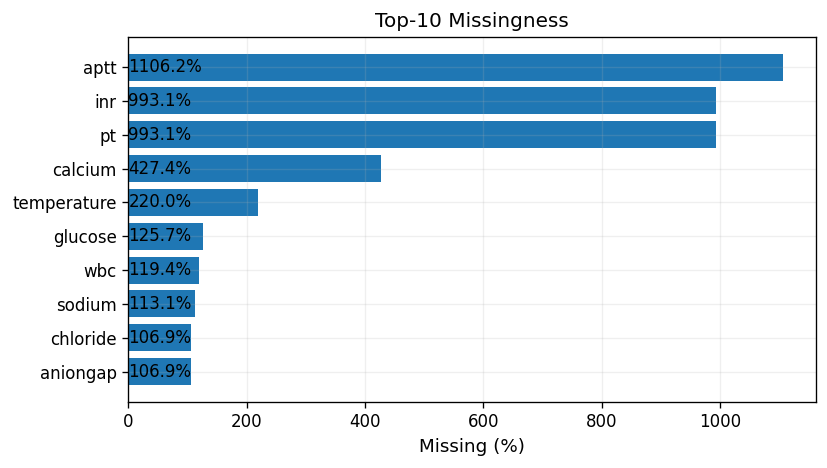

[save] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/overview_missing_top10.png


In [6]:
# %% [missingness]
miss_df = None
if (PROC_DIR / "missingness_overview.csv").exists():
    miss_df = pd.read_csv(PROC_DIR / "missingness_overview.csv")
    # 兼容字段名
    if "pct_missing" not in miss_df.columns:
        # 尝试补算
        if {"n_missing","n"}.issubset(miss_df.columns):
            miss_df["pct_missing"] = miss_df["n_missing"] / miss_df["n"]
else:
    n = len(df)
    miss_df = (
        df.isna().sum().rename("n_missing").reset_index().rename(columns={"index":"column"})
    )
    miss_df["n"] = n
    miss_df["pct_missing"] = miss_df["n_missing"] / miss_df["n"]
    miss_df["dtype"] = miss_df["column"].map(lambda c: str(df[c].dtype))

miss_top = miss_df.sort_values("pct_missing", ascending=False).head(10).copy()
display(miss_top)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(miss_top["column"], miss_top["pct_missing"]*100)
ax.invert_yaxis()
for ytick, v in zip(ax.get_yticks(), miss_top["pct_missing"].values):
    ax.text(0.5, ytick, f"{v*100:.1f}%", va="center")
ax.set_xlabel("Missing (%)")
ax.set_title("Top-10 Missingness")
fig.tight_layout()
out_path = FIG_DIR / "overview_missing_top10.png"
fig.savefig(out_path)
plt.show()
print(f"[save] {out_path}")

## 5. 相关矩阵（数值变量）
- 针对数值列计算皮尔逊相关
- 绘制相关矩阵（matshow），并保存 PNG

> 若变量较多，可只取前 30 列演示，以保证图像可读性。

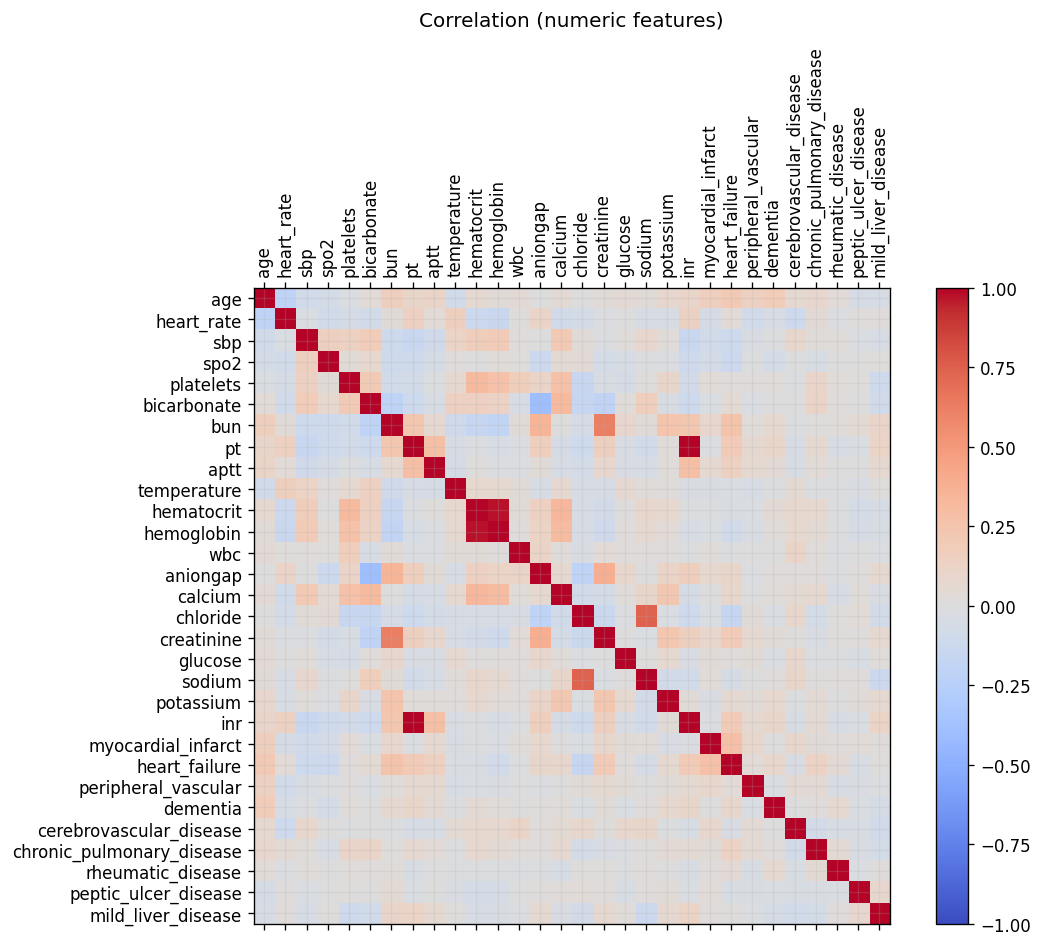

[save] /public/home/aojiang/海南医科大学/icu-lymphoma-ml-repro/outputs/figures/overview_corr_numeric.png


In [7]:
# %% [correlation matrix]
NUM_LIMIT = 30
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != OUTCOME]
if len(num_cols) == 0:
    print("[skip] 无数值变量，跳过相关矩阵绘制。")
else:
    cols_sub = num_cols[:NUM_LIMIT]
    corr = df[cols_sub].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(min(10, 0.35*len(cols_sub)+3), min(8, 0.35*len(cols_sub)+3)))
    cax = ax.matshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ax.set_xticks(range(len(cols_sub)))
    ax.set_xticklabels(cols_sub, rotation=90)
    ax.set_yticks(range(len(cols_sub)))
    ax.set_yticklabels(cols_sub)
    ax.set_title("Correlation (numeric features)", pad=12)
    fig.tight_layout()
    out_path = FIG_DIR / "overview_corr_numeric.png"
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"[save] {out_path}")

## 6. 快速小结
- 数据来源、样本量、结局阳性率（如有）
- 缺失变量 TOP10 的提示
- 建议下一步运行 `src.preprocess` / `src.multiple_imputation` / `src.train`

（本 Notebook 仅做**概览**，避免与脚本功能重复。）

In [8]:
# %% [summary]
summary = {
    "data_source": data_source,
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "outcome": OUTCOME,
}
if OUTCOME in df.columns:
    prev = float(df[OUTCOME].astype(int).mean()) if len(df)>0 else float("nan")
    summary["prevalence"] = prev
print(json.dumps(summary, indent=2, ensure_ascii=False))
print("[next] 可继续：preprocess → multiple_imputation → feature_select → train → evaluate → threshold_scan → subgroup_eval → report_export")

{
  "data_source": "data_processed/features_processed.parquet",
  "n_rows": 1591,
  "n_cols": 39,
  "outcome": "mor_hospital",
  "prevalence": 0.21495914519170334
}
[next] 可继续：preprocess → multiple_imputation → feature_select → train → evaluate → threshold_scan → subgroup_eval → report_export
